In [1]:
# import libraries
import os
import sys

import pandas as pd
import numpy as np
import sqlite3
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import random
import time
from PIL import Image
# !pip install wordcloud
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import ast
import re

In [2]:
# Plotly packages
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [3]:
# connect to music sqlite3 database 
conn = sqlite3.connect('music.db')
c = conn.cursor()

In [4]:
tracks = pd.read_sql("SELECT * FROM track", conn)
af = pd.read_sql("SELECT * FROM audio_features", conn)
artists = pd.read_sql("SELECT * FROM artist", conn)
lyrics = pd.read_sql("SELECT * FROM lyrics", conn)
bb100 = pd.read_sql("SELECT * FROM bb100", conn)

In [5]:
tracks.columns, af.columns, artists.columns, lyrics.columns, bb100.columns

(Index(['album_name', 'album_id', 'artist_name', 'artist_id', 'disc_number',
        'duration_ms', 'explicit', 'external_urls', 'href', 'id', 'name',
        'popularity', 'track_number', 'type', 'uri'],
       dtype='object'),
 Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
        'time_signature'],
       dtype='object'),
 Index(['external_urls', 'followers', 'genre', 'href', 'id', 'name',
        'popularity', 'type'],
       dtype='object'),
 Index(['song_name', 'text', 'song_name_orig', 'spotify_id'], dtype='object'),
 Index(['Song', 'Artist', 'Rank_Default', 'Rank_LastWeek', 'Rank_Peak',
        'Num_Weeks_on_Chart', 'Curr_Week'],
       dtype='object'))

In [65]:
# Filter current working df to CURRENT WEEK:

query = """
SELECT * 
FROM track
INNER JOIN audio_features
ON track.id = audio_features.id;
"""

temp0 = pd.read_sql(query, conn)

print(temp0.shape)

curr_week = '2020-04-18'   # change to the week you want
bb100_curr = bb100[bb100['Curr_Week'] == curr_week]

temp1 = pd.merge(bb100_curr, temp0, left_on='Song', right_on='name', how='left')

(145, 33)


In [66]:
temp1.shape

(100, 40)

In [69]:
# TODO: figure out why some rows have MISSING Spotify data
temp1[temp1.isna().any(axis=1)]

,Song,Artist,Rank_Default,Rank_LastWeek,Rank_Peak,Num_Weeks_on_Chart,Curr_Week,album_name,album_id,artist_name,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
4,Life Is Good,Future Featuring Drake,0.0,5.0,2,13,2020-04-18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,My Oh My,Camila Cabello Featuring DaBaby,2.0,15.0,13,18,2020-04-18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,Roxanne,Arizona Zervas,-5.0,11.0,4,23,2020-04-18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,Hot Girl Bummer,blackbear,-1.0,16.0,11,30,2020-04-18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,Find My Way,DaBaby,0.0,0.0,22,1,2020-04-18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,Nobody But You,Blake Shelton Duet With Gwen Stefani,8.0,32.0,24,13,2020-04-18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,Ballin',Mustard & Roddy Ricch,-2.0,24.0,11,38,2020-04-18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,Catch,Brett Young,11.0,40.0,29,11,2020-04-18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,Roses (Imanbek Remix),SAINt JHN,9.0,39.0,30,3,2020-04-18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,High Fashion,Roddy Ricch Featuring Mustard,0.0,31.0,20,15,2020-04-18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Audio Features Heatmap

In [9]:
temp2 = temp1[['popularity','duration_ms', 'time_signature', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']]

# calculate af correations
corr2 = temp2.corr() 

In [10]:
fig = px.imshow(
    corr2,
    labels=dict(color="Correlation"),
    x=temp2.columns,
    y=temp2.columns,
    color_continuous_scale='Viridis'
    )

fig.update_layout(
    title="Audio Features")

fig.show()

# Radar Chart for indivd song's Audio Features

In [11]:
# Test Radar Chart - chart for individ songs only
song1 = temp2[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']].iloc[4]
TEST = pd.DataFrame(dict(
    r=song1.values,
    theta=list(song1.index)))
fig = px.line_polar(TEST, r='r', theta='theta', line_close=True)
fig.update_traces(fill='toself')
fig.show()

# Histograms for aggregate Audio Features and Popularity

In [12]:
# # stack or overlap two+ distribs
# fig = go.Figure()

# fig.add_trace(go.Histogram(x=temp1['danceability'], nbinsx=50))
# fig.add_trace(go.Histogram(x=temp2['energy'], nbinsx=50))
# # Overlay both histograms
# fig.update_layout(barmode='stack')   # change to either 'stack' or 'overlay'
# # Reduce opacity to see both histograms
# # fig.update_traces(opacity=0.75)
# fig.show()

In [18]:
feature = 'danceability'
title = f"Histogram of {feature}"
fig = px.histogram(temp1, title=title, x=feature, nbins=30, histnorm='probability density')
fig.show()


In [17]:
feature = 'duration_ms'
title = f"Histogram of {feature}"
fig = px.histogram(temp1, title=title, x=feature, nbins=30, histnorm='probability density')
fig.show()


In [19]:
feature = 'energy'
title = f"Histogram of {feature}"
fig = px.histogram(temp1, title=title, x=feature, nbins=30, histnorm='probability density')
fig.show()


# Artist data visuaizations

In [25]:
# # artist counts (who has the most num of songs?)
# plt.figure(figsize=[8,6])
# ax = sns.countplot(x="artist_name", data=tracks, order=tracks['artist_name'].value_counts()[0:10].index)
# plt.xlabel('Artist Name')
# plt.title('Top 10 Artists')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# # plt.savefig("IMAGENAME.png", format="png")

## Genres Wordcloud
All artists combined

In [24]:
type(artists['genre'].iloc[0])

str

Text(0.5, 1.0, 'Top Genres')

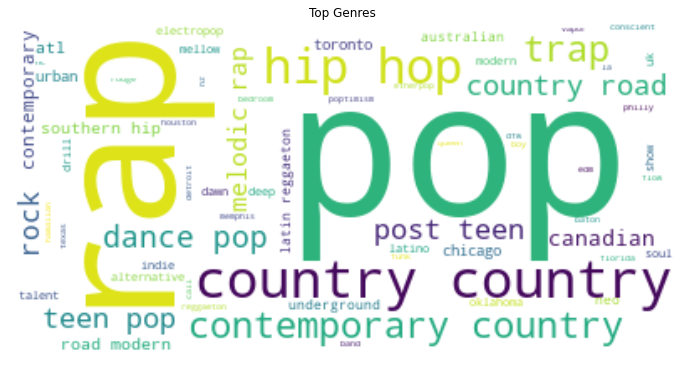

In [27]:
# list of strings
genre_list = [row for row in artists['genre'].str.strip(to_strip=".!? \n\t\'")]  
genre_text = " ".join(str(l) for l in genre_list)
genre_text2 = re.sub('[^A-Za-z]+', ' ', genre_text).strip()

wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(genre_text2)
plt.figure(figsize=[12,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Top Genres')

## Lyrics Wordcloud
### All songs combined

In [29]:
# list of strings
lyric_list = [row for row in lyrics['text'].str.strip(to_strip=".!? \n\t\'")]  

In [30]:
lyric_text = " ".join(str(l) for l in lyric_list)
lyric_text2 = re.sub('[^A-Za-z]+', ' ', lyric_text).strip()

Text(0.5, 1.0, 'Top Words in Lyrics')

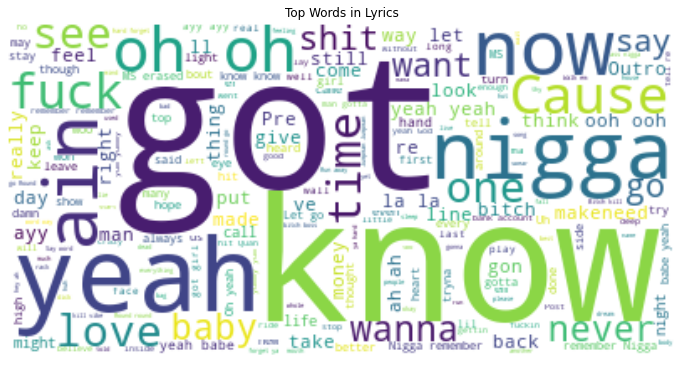

In [33]:
# Lyric wordcloud with updated/custom stopwords
sw2 = set(STOPWORDS)
sw2.update(['intro', 'verse', 'chorus', 'bridge', 'don'])

wordcloud2 = WordCloud(stopwords=sw2, background_color="white").generate(lyric_text2)

plt.figure(figsize=[12,10])
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.title('Top Words in Lyrics')


# Bar Charts

In [38]:
top15 = artists.sort_values(by='followers', ascending=False).iloc[0:15]



,external_urls,followers,genre,href,id,name,popularity,type
85,https://open.spotify.com/artist/3TVXtAsR1Inumw...,46197936,"canadian hip hop, canadian pop, hip hop, pop r...",https://api.spotify.com/v1/artists/3TVXtAsR1In...,3TVXtAsR1Inumwj472S9r4,Drake,100,artist
52,https://open.spotify.com/artist/1uNFoZAHBGtllm...,34498280,"canadian pop, pop, post-teen pop",https://api.spotify.com/v1/artists/1uNFoZAHBGt...,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,94,artist
37,https://open.spotify.com/artist/7dGJo4pcD2V6oG...,34480181,"detroit hip hop, g funk, hip hop, rap",https://api.spotify.com/v1/artists/7dGJo4pcD2V...,7dGJo4pcD2V6oG8kP0tJRR,Eminem,94,artist
82,https://open.spotify.com/artist/06HL4z0CvFAxyc...,28692456,"dance pop, pop, post-teen pop",https://api.spotify.com/v1/artists/06HL4z0CvFA...,06HL4z0CvFAxyc27GXpf02,Taylor Swift,92,artist
33,https://open.spotify.com/artist/6qqNVTkY8uBg9c...,25220952,"electropop, pop",https://api.spotify.com/v1/artists/6qqNVTkY8uB...,6qqNVTkY8uBg9cP3Jd7DAH,Billie Eilish,95,artist
22,https://open.spotify.com/artist/246dkjvS1zLTti...,24667078,"dfw rap, melodic rap, rap",https://api.spotify.com/v1/artists/246dkjvS1zL...,246dkjvS1zLTtiykXe5h60,Post Malone,95,artist
57,https://open.spotify.com/artist/04gDigrS5kc9YW...,23974225,"pop, pop rock",https://api.spotify.com/v1/artists/04gDigrS5kc...,04gDigrS5kc9YWfZHwBETP,Maroon 5,89,artist
73,https://open.spotify.com/artist/4q3ewBCX7sLwd2...,20894383,"latin, reggaeton, trap latino",https://api.spotify.com/v1/artists/4q3ewBCX7sL...,4q3ewBCX7sLwd24euuV69X,Bad Bunny,99,artist
17,https://open.spotify.com/artist/0C8ZW7ezQVs4UR...,20359971,"dance pop, pop, post-teen pop",https://api.spotify.com/v1/artists/0C8ZW7ezQVs...,0C8ZW7ezQVs4URX5aX7Kqx,Selena Gomez,89,artist
3,https://open.spotify.com/artist/1Xyo4u8uXC1ZmM...,20147812,"canadian contemporary r&b, canadian pop, pop",https://api.spotify.com/v1/artists/1Xyo4u8uXC1...,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,97,artist


In [51]:
# bar chart number followers top 15 artists
fig = go.Figure(data=[
    go.Bar(name='followers', x=top15['name'], y=top15['followers'])
])
# # Change the bar mode
# fig.update_layout(barmode='overlay')

fig.update_layout(title_text="Top 15 Artists - Number of Spotify Followers")

fig.show()